In [1]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Real-World Dataset Example: Wine Quality Prediction

This notebook demonstrates Machine Gnostics Linear Regression on a real dataset from the UCI repository.

### **Overview**
The **Machine Gnostics LinearRegressor** excels on real-world datasets that often contain noise, outliers, and heterogeneous data distributions. This example uses the **Wine Quality Dataset** from UCI to demonstrate:

- Automatic robustness to data quality issues
- Training history tracking to monitor convergence
- Multiple evaluation metrics for model assessment
- Cross-validation for reliable performance estimates

**Dataset:** Wine Quality (UCI Repository)
- **Features:** 11 physicochemical properties (acidity, sulfur, alcohol, etc.)
- **Target:** Wine quality score (0-10)
- **Samples:** ~6500 wine samples

In [2]:
# Install UCI dataset repository package
# !pip install ucimlrepo  # Uncomment if needed

## Example 1: Simple Usage with Real Dataset

Load data, split into train/test, and fit the model.

In [3]:
import numpy as np
from ucimlrepo import fetch_ucirepo
from machinegnostics.models import LinearRegressor, train_test_split

# Fetch Wine Quality dataset
wine_quality = fetch_ucirepo(id=186)
X = np.array(wine_quality.data.features)
y = np.array(wine_quality.data.targets).flatten()

# Select only 5% of data randomly
np.random.seed(42)
n_samples = int(0.05 * len(X))
random_indices = np.random.choice(len(X), size=n_samples, replace=False)
X = X[random_indices]
y = y[random_indices]

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Target range: {y.min():.1f} to {y.max():.1f}")

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_seed=42)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set:  {X_test.shape[0]} samples")

Dataset loaded: 324 samples, 11 features
Target range: 3.0 to 8.0

Train set: 259 samples
Test set:  65 samples


In [10]:
# Fit the model
model = LinearRegressor(verbose=False, early_stopping=True, tolerance=0.01)
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Model fitted successfully!")
print(f"Number of coefficients: {len(model.coefficients)}")
print(f"Training complete after {len([h for h in model._history if h['h_loss'] is not None])} iterations")

Model fitted successfully!
Number of coefficients: 12
Training complete after 2 iterations


### Basic Visualization: True vs Predicted

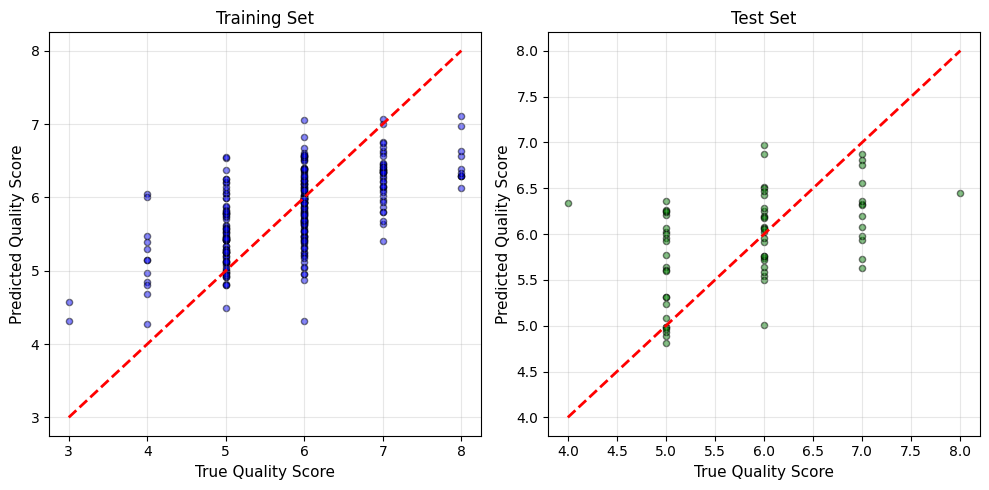

Note: Points closer to the red diagonal line indicate better predictions


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot for train set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue', edgecolor='k', s=20)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('True Quality Score', fontsize=11)
plt.ylabel('Predicted Quality Score', fontsize=11)
plt.title(f'Training Set')
plt.grid(True, alpha=0.3)

# Plot for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green', edgecolor='k', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Quality Score', fontsize=11)
plt.ylabel('Predicted Quality Score', fontsize=11)
plt.title(f'Test Set')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Points closer to the red diagonal line indicate better predictions")

## Example 2: Understanding Training History

Track how the model converges during training by examining loss, entropy, and weights.

In [12]:
# Access training history
history = model._history
history_valid = [h for h in history if h['h_loss'] is not None]

print("Training History Summary:")
print("-" * 50)
print(f"Total iterations: {len(history_valid)}")
print(f"Initial loss:     {history_valid[0]['h_loss']:.6f}")
print(f"Final loss:       {history_valid[-1]['h_loss']:.6f}")
print(f"Initial entropy:  {history_valid[0]['rentropy']:.6f}")
print(f"Final entropy:    {history_valid[-1]['rentropy']:.6f}")
print(f"\nConvergence: Loss decreased by {((history_valid[0]['h_loss'] - history_valid[-1]['h_loss']) / history_valid[0]['h_loss'] * 100):.2f}%")

Training History Summary:
--------------------------------------------------
Total iterations: 2
Initial loss:     100.347404
Final loss:       101.884619
Initial entropy:  0.055440
Final entropy:    0.054289

Convergence: Loss decreased by -1.53%


### Visualize Training Convergence

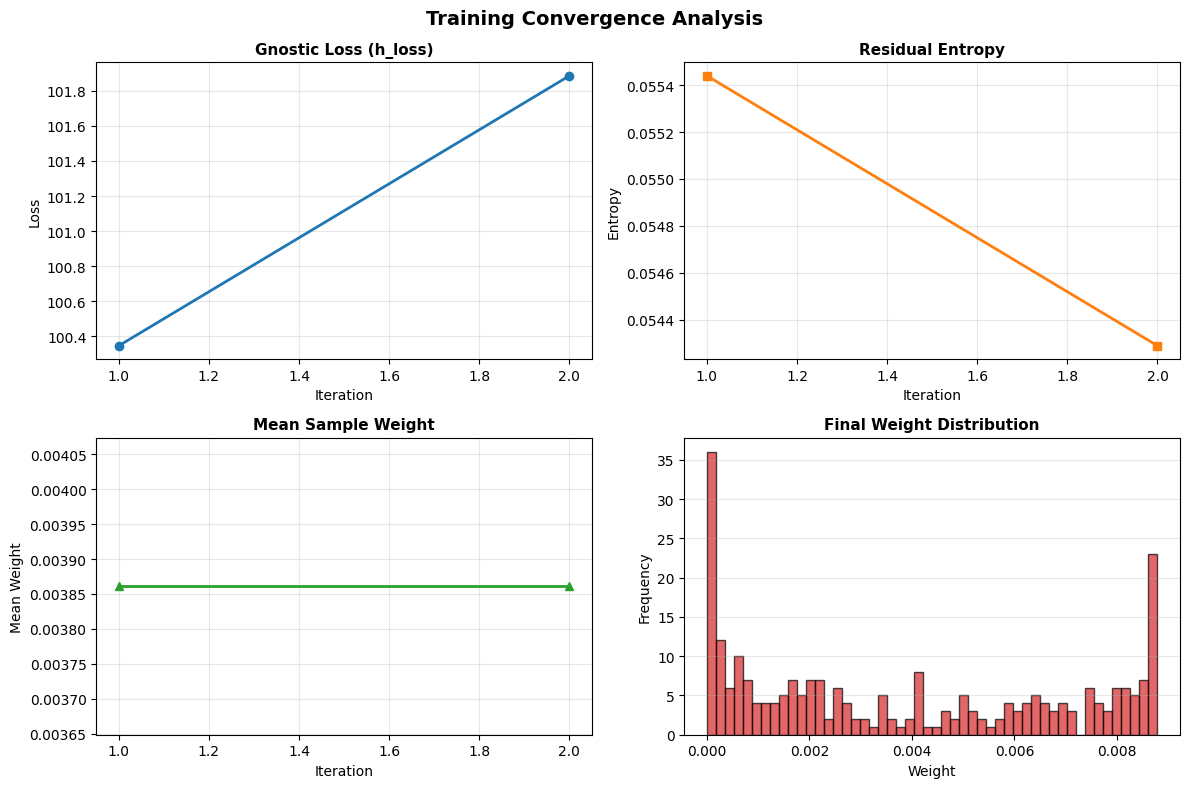


Key Observations:
- Loss and entropy decrease → model is learning
- Weights stabilize → robust sample weighting achieved
- Weight distribution shows automatic outlier down-weighting


In [13]:
# Extract metrics from history
iterations = [h['iteration'] for h in history_valid]
h_loss = [h['h_loss'] for h in history_valid]
rentropy = [h['rentropy'] for h in history_valid]
mean_weights = [np.mean(h['weights']) for h in history_valid]

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss over iterations
axes[0, 0].plot(iterations, h_loss, marker='o', color='tab:blue', linewidth=2)
axes[0, 0].set_title('Gnostic Loss (h_loss)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Entropy over iterations
axes[0, 1].plot(iterations, rentropy, marker='s', color='tab:orange', linewidth=2)
axes[0, 1].set_title('Residual Entropy', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Entropy')
axes[0, 1].grid(True, alpha=0.3)

# Mean weights over iterations
axes[1, 0].plot(iterations, mean_weights, marker='^', color='tab:green', linewidth=2)
axes[1, 0].set_title('Mean Sample Weight', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mean Weight')
axes[1, 0].grid(True, alpha=0.3)

# Weight distribution (final iteration)
final_weights = history_valid[-1]['weights']
axes[1, 1].hist(final_weights, bins=50, color='tab:red', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Final Weight Distribution', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Weight')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Training Convergence Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Loss and entropy decrease → model is learning")
print("- Weights stabilize → robust sample weighting achieved")
print("- Weight distribution shows automatic outlier down-weighting")

## Example 3: Cross-Validation

Evaluate model performance using k-fold cross-validation for reliable estimates.

In [14]:
from machinegnostics.models import CrossValidator
from machinegnostics.metrics import mean_absolute_error

# Create fresh model for CV
cv_model = LinearRegressor(verbose=False, early_stopping=True)

# Perform 5-fold cross-validation
cv = CrossValidator(model=cv_model, X=X, y=y, k=5, random_seed=42)
cv_results = cv.evaluate(mean_absolute_error)

print("5-Fold Cross-Validation Results (MAE):")
print("=" * 50)
for fold, mae in enumerate(cv_results, 1):
    print(f"Fold {fold}: MAE = {mae:.4f}")

print("=" * 50)
print(f"Average MAE: {np.mean(cv_results):.4f} ± {np.std(cv_results):.4f}")
print(f"Min MAE:     {np.min(cv_results):.4f}")
print(f"Max MAE:     {np.max(cv_results):.4f}")

5-Fold Cross-Validation Results (MAE):
Fold 1: MAE = 0.5526
Fold 2: MAE = 0.3560
Fold 3: MAE = 0.5622
Fold 4: MAE = 0.4543
Fold 5: MAE = 0.3371
Average MAE: 0.4524 ± 0.0945
Min MAE:     0.3371
Max MAE:     0.5622


In [15]:
# Compare multiple metrics
from machinegnostics.metrics import mean_squared_error, root_mean_squared_error

metrics = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'RMSE': root_mean_squared_error
}

print("\nCross-Validation with Multiple Metrics:")
print("=" * 60)

for metric_name, metric_func in metrics.items():
    cv = CrossValidator(model=cv_model, X=X, y=y, k=5, random_seed=42)
    results = cv.evaluate(metric_func)
    
    print(f"\n{metric_name}:")
    print(f"  Mean:   {np.mean(results):.4f}")
    print(f"  Std:    {np.std(results):.4f}")
    print(f"  Min:    {np.min(results):.4f}")
    print(f"  Max:    {np.max(results):.4f}")

print("\n" + "=" * 60)
print("Note: Lower values indicate better model performance")


Cross-Validation with Multiple Metrics:

MAE:
  Mean:   0.4524
  Std:    0.0945
  Min:    0.3371
  Max:    0.5622

MSE:
  Mean:   0.2144
  Std:    0.0560
  Min:    0.1099
  Max:    0.2728

RMSE:
  Mean:   0.4582
  Std:    0.0666
  Min:    0.3315
  Max:    0.5223

Note: Lower values indicate better model performance
